# 0.0) Import das Bibliotecas

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

from IPython.display import Image
from datetime import datetime, timedelta

sns.set_theme()
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = (18, 10)

### 0.1) Funções Auxiliares

In [2]:
def format_col_name(col):
    list_str = re.findall('[A-Z][^A-Z]*', col)

    return '_'.join(list_str).lower()

### 0.2) Coleta dos Dados

In [3]:
df_train = pd.read_csv('data/train.csv', nrows=100000)
df_store = pd.read_csv('data/store.csv')

In [4]:
df_raw = df_train.merge(df_store, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


# 1.0) Descrição dos Dados

In [5]:
df1 = df_raw.copy()

In [6]:
print(f'Total de linhas: {df1.shape[0]:,}')
print(f'Total de colunas: {df1.shape[1]}')

Total de linhas: 100,000
Total de colunas: 18


### 1.1) Renomear colunas

In [7]:
for col in df1.columns:
    print(col, end=' | ')

Store | DayOfWeek | Date | Sales | Customers | Open | Promo | StateHoliday | SchoolHoliday | StoreType | Assortment | CompetitionDistance | CompetitionOpenSinceMonth | CompetitionOpenSinceYear | Promo2 | Promo2SinceWeek | Promo2SinceYear | PromoInterval | 

In [8]:
df1.columns = [format_col_name(col) for col in df1.columns]

### 1.2) Tipos dos Dados

In [9]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.3) Valores NAs

In [10]:
df1.isna().sum()

store                               0
day_of_week                         0
date                                0
sales                               0
customers                           0
open                                0
promo                               0
state_holiday                       0
school_holiday                      0
store_type                          0
assortment                          0
competition_distance              269
competition_open_since_month    31746
competition_open_since_year     31746
promo2                              0
promo2_since_week               48785
promo2_since_year               48785
promo_interval                  48785
dtype: int64

### 1.4) Tratando valores NAs

In [11]:
df1.fillna(0, inplace=True)

In [12]:
df1.isna().sum().sum()

0

### 1.5) Corrigindo Tipos dos Dados

In [13]:
# date -> datetime
df1['date'] = pd.to_datetime(df1['date'])

# open -> bool
df1['open'] = df1['open'].astype(bool)

# promo -> bool
df1['promo'] = df1['open'].astype(bool)

# SchoolHoliday -> bool
df1['school_holiday'] = df1['open'].astype(bool)

# promo2 -> bool
df1['promo2'] = df1['open'].astype(bool)

# competition_open_since_year -> int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# competition_open_since_month -> int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

# promo2_since_year -> int
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

# promo2_since_week -> int
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

### 1.6) Linhas duplicadas

In [14]:
df1.duplicated().sum()

0

### 1.7) Estatísticas de Resumo

In [15]:
num_attr, cat_attr = df1.select_dtypes(include=['int', 'float']), df1.select_dtypes(exclude=['int', 'float'])

**Variáveis Numéricas**

In [16]:
num_stats = pd.concat([num_attr.describe().T, pd.DataFrame({'skew': num_attr.skew(), 'kurtosis': num_attr.kurtosis()})], axis=1)
num_stats

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
store,100000.00,556.66,321.58,1.00,278.00,556.00,835.00,1115.00,0.01,-1.20
day_of_week,100000.00,3.97,2.00,1.00,2.00,4.00,6.00,7.00,0.03,-1.24
sales,100000.00,5997.44,3871.15,0.00,4022.00,6034.00,8121.00,41551.00,0.53,1.62
customers,100000.00,631.24,457.24,0.00,420.00,612.00,826.00,5192.00,1.70,8.06
competition_distance,100000.00,5391.44,7656.84,0.00,710.00,2320.00,6880.00,75860.00,2.93,13.07
competition_open_since_month,100000.00,4.93,4.28,0.00,0.00,4.00,9.00,12.00,0.19,-1.45
competition_open_since_year,100000.00,1371.00,935.03,0.00,0.00,2006.00,2011.00,2015.00,-0.78,-1.38
promo2_since_week,100000.00,12.08,15.54,0.00,0.00,1.00,22.00,50.00,0.95,-0.62
promo2_since_year,100000.00,1030.32,1005.59,0.00,0.00,2009.00,2012.00,2015.00,-0.05,-2.00


**Variáveis Categóricas**

In [17]:
cat_stats = pd.concat([cat_attr.describe().T, pd.DataFrame({'skew': cat_attr.skew(), 'kurtosis': cat_attr.kurtosis()})], axis=1)
cat_stats

,count,unique,top,freq,first,last,skew,kurtosis
date,100000,90,2015-07-31 00:00:00,1115,2015-05-03,2015-07-31,NaN,NaN
open,100000,2,True,83346,NaT,NaT,-1.79,1.20
promo,100000,2,True,83346,NaT,NaT,-1.79,1.20
state_holiday,100000,2,0,97004,NaT,NaT,NaN,NaN
school_holiday,100000,2,True,83346,NaT,NaT,-1.79,1.20
store_type,100000,4,a,53983,NaT,NaT,NaN,NaN
assortment,100000,3,a,53181,NaT,NaT,NaN,NaN
promo2,100000,2,True,83346,NaT,NaT,-1.79,1.20
promo_interval,100000.00,4.00,0.00,48785.00,NaT,NaT,NaN,NaN


# 2.0) Feature Engineering

In [18]:
df2 = df1.copy()

### 2.1) Mindmap de Hipóteses

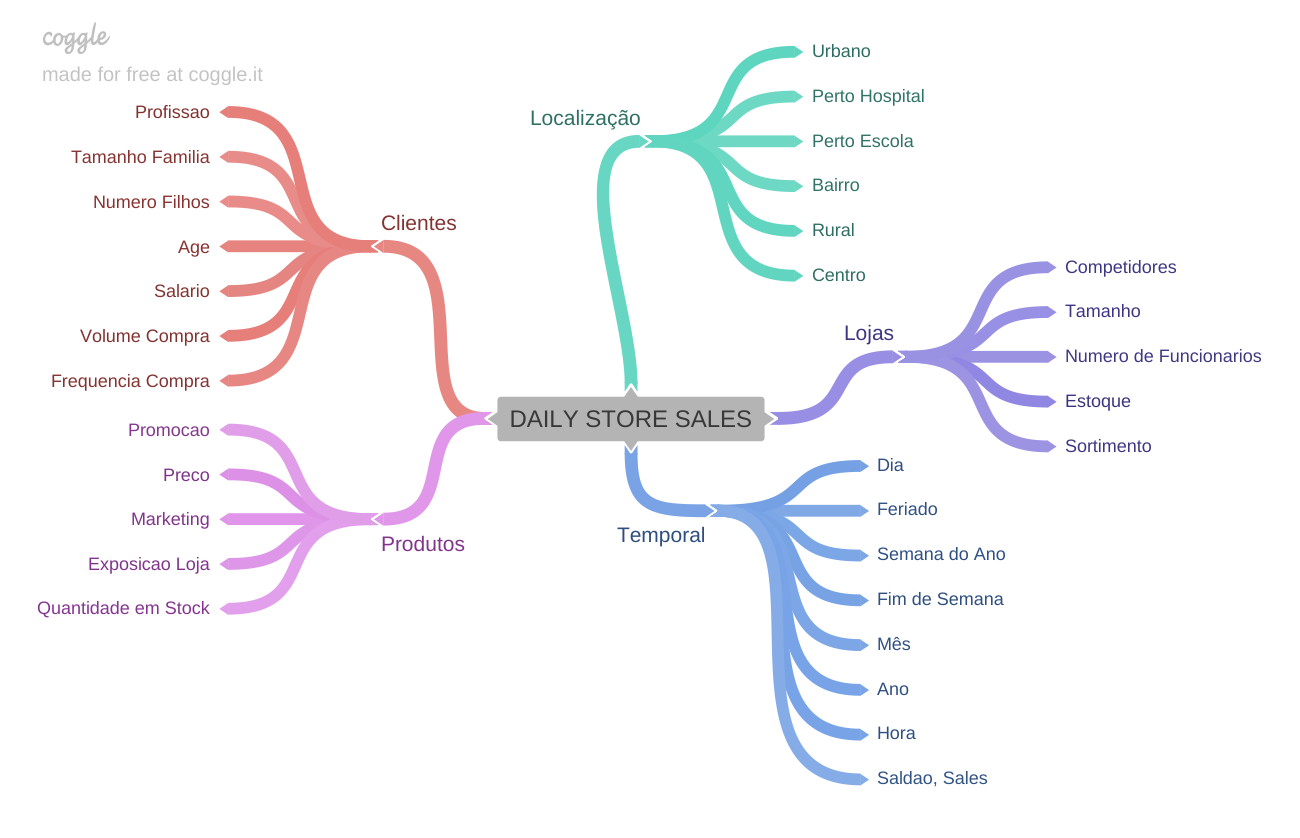

In [19]:
Image('img/DAILY_STORE_SALES.png')

### 2.2) Criação das Hipóteses

#### 2.2.1. Hipoteses Loja
1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

#### 2.2.2. Hipoteses Produto
1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

#### 2.2.3. Hipoteses Tempo
1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

### 2.3) Lista Final de Hipóteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

### 2.4) Feature Engineering

In [20]:
# day
df2['day'] = df2['date'].dt.day

# month
df2['month'] = df2['date'].dt.month

# year
df2['year'] = df2['date'].dt.year

# week_of_year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# assortment
assortment_map = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
df2['assortment'] = df2['assortment'].map(assortment_map)

# state_holiday
state_holiday_map = { 'a': 'public holiday', 'b': 'Easter holiday', 'c': 'Christmas', '0': 'regular_day'}
df2['state_holiday'] = df2['state_holiday'].map(state_holiday_map)

# competition_open_since
df2['competition_open_since'] = df2.apply(lambda x: datetime(year=x['competition_open_since_year'] if x['competition_open_since_year'] != 0 else x['date'].year, \
    month=x['competition_open_since_month'] if x['competition_open_since_month'] != 0 else x['date'].month, day=1), axis=1)

# competition_duration
df2['competition_duration'] = df2.apply(lambda x: np.round((x['date'] - x['competition_open_since']).days / 30).astype(int) if x['date'] > x['competition_open_since']  else 0, axis=1)

# promo2_since
df2['promo2_since'] = df2.apply(lambda x: f"{x['promo2_since_year']}-{x['promo2_since_week']}" if  x['promo2_since_year'] != 0 else x['date'].strftime('%Y-%W'), axis=1)

df2['promo2_since'] = df2['promo2_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo2_since'] ) / 7 ).apply(lambda x: x.days ).astype( int )

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', \
    8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df2['month_map'] = df2['month'].map( month_map )
df2['is_promo'] = df2[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 \
    if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 ).astype('bool')

# 3.0) Filtragem de Variáveis

In [29]:
df3 = df2.copy()

### 3.1) Filtragem das Linhas

In [30]:
df3 = df3.query('open == True & sales > 0')

### 3.2) Seleção das Colunas

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
#cols_drop_2 = ['customers', 'open', 'competition_open_since_month',
#       'competition_open_since_year', 'promo2_since_week',
#       'promo2_since_year', 'promo_interval', 'month_map']

df3.drop(columns=cols_drop, inplace=True)

# 4.0) Análise Exploratória de Dados

In [32]:
df4 = df3.copy()

### 4.1) Análise Univariada

#### 4.1.2) Variável Target

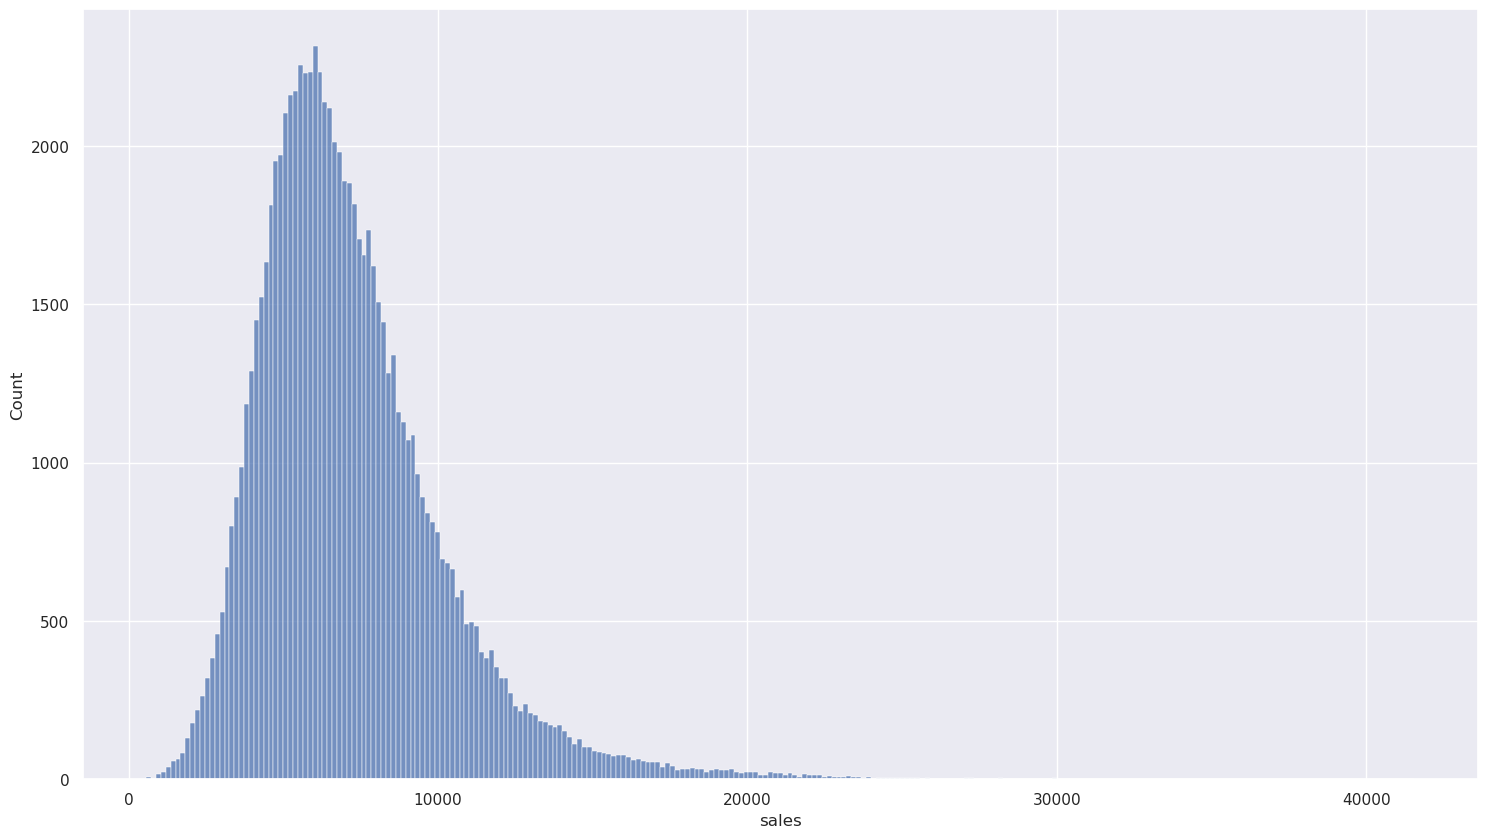

In [63]:
sns.histplot(df4['sales']);

#### 4.1.2) Variáveis Numéricas

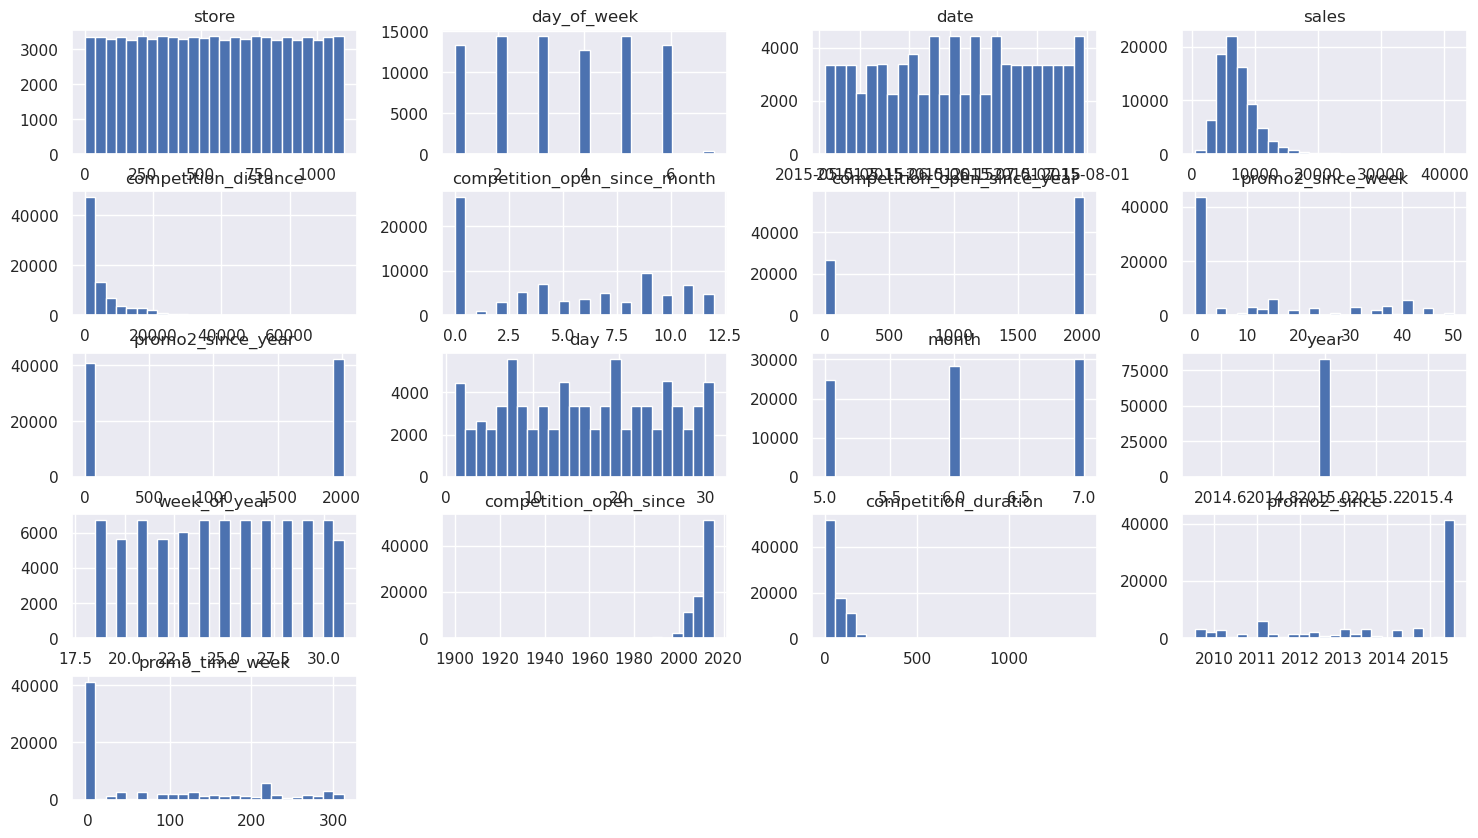

In [64]:
num_attr = df4.select_dtypes(include=[int, float, 'datetime64[ns]'])
num_attr.hist(bins=25);

#### 4.1.3) Variáveis Categóricas

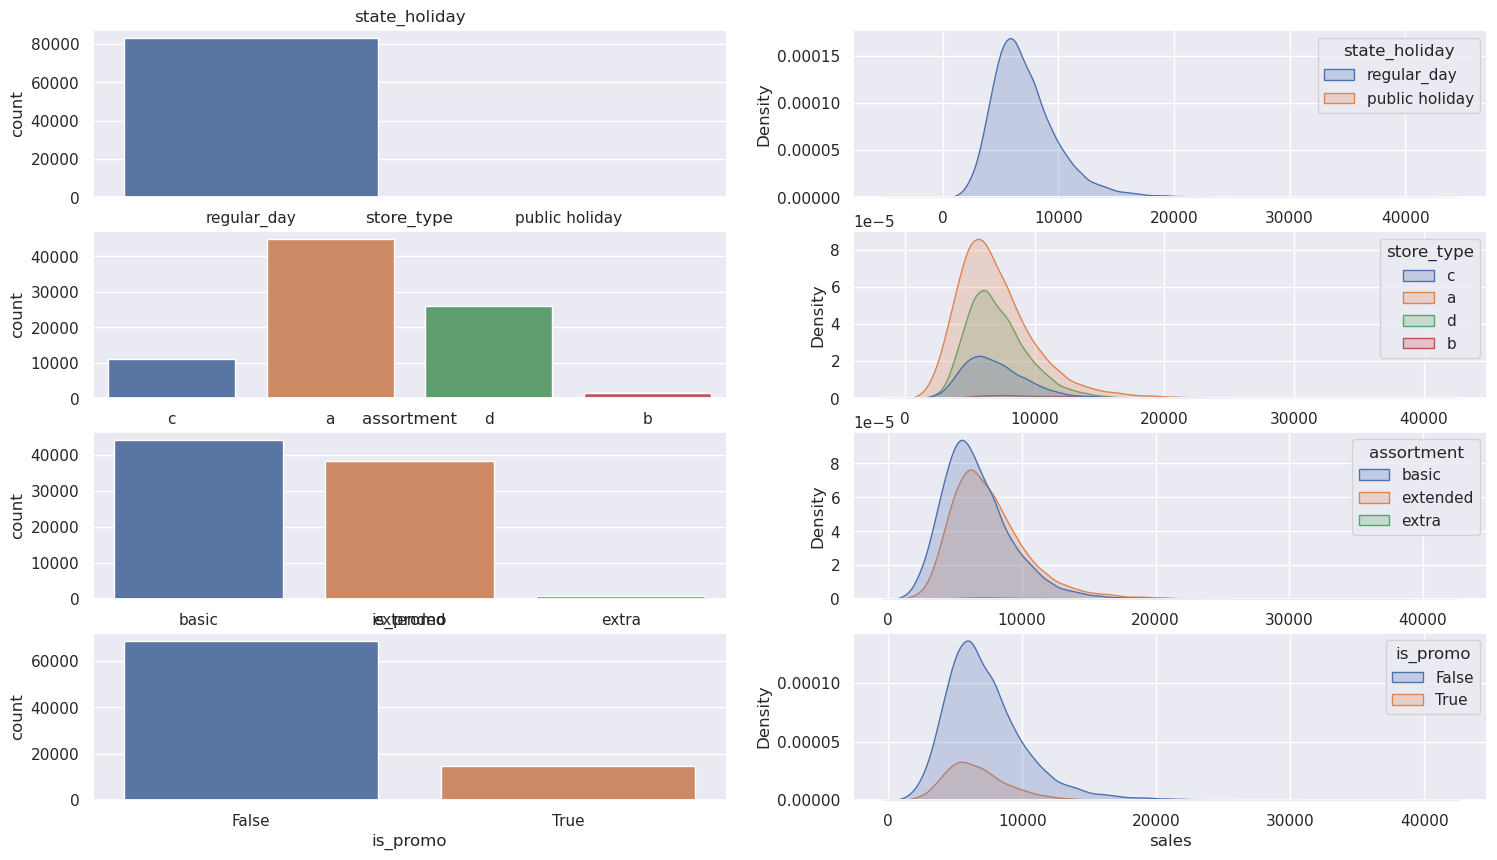

In [81]:
fig, ax = plt.subplots(4, 2)

# state_holiday
sns.countplot(data=df4, x='state_holiday', ax=ax[0, 0])

sns.kdeplot(data=df4, x='sales', hue='state_holiday', fill=True, ax=ax[0, 1])
ax[0, 0].set_title('state_holiday', fontsize=12)

# store_type
sns.countplot(data=df4, x='store_type', ax=ax[1, 0])

sns.kdeplot(data=df4, x='sales', hue='store_type', fill=True, ax=ax[1, 1])
ax[1, 0].set_title('store_type', fontsize=12)

# assortment
sns.countplot(data=df4, x='assortment', ax=ax[2, 0])

sns.kdeplot(data=df4, x='sales', hue='assortment', fill=True, ax=ax[2, 1])
ax[2, 0].set_title('assortment', fontsize=12)

# is_promo
sns.countplot(data=df4, x='is_promo', ax=ax[3, 0])

sns.kdeplot(data=df4, x='sales', hue='is_promo', fill=True, ax=ax[3, 1])
ax[3, 0].set_title('is_promo', fontsize=12)

plt.show()

### 4.2) Análise Bivariada

#### H1. Lojas com maior sortimentos deveriam vender mais.

In [ ]:
df_h1

#### H2. Lojas com competidores mais próximos deveriam vender menos.

#### H3. Lojas com competidores à mais tempo deveriam vendem mais.

#### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

#### H5. Lojas com mais dias de promoção deveriam vender mais.

#### H7. Lojas com mais promoções consecutivas deveriam vender mais.

#### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.

#### H9. Lojas deveriam vender mais ao longo dos anos.

#### H10. Lojas deveriam vender mais no segundo semestre do ano.

#### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.

#### H12. Lojas deveriam vender menos aos finais de semana.

#### H13. Lojas deveriam vender menos durante os feriados escolares.

### 4.3) Análise Multivariada